# Numba version

In this notebook we update and improve the agents and environments presented in `rl_opts.rl_framework`. Two main changes:

- we use `numba` to improve speed.
- we implement more efficient ways of updating the H and G matrix (contribution by Dr. Michele Caraglio).
- we consider as base case `num_agents = 1`. In previous versions we had this as an input which overcomplicated all functions.

In [ ]:
#| default_exp numba.rl_framework

#| hide
# Libs

Class that defines the foraging environment

In [4]:
#| export
import numpy as np
import numba
from numba.experimental import jitclass
from numba import jit, float64, int64, bool_, prange, njit
import math
import random
#from rl_opts.utils import isBetween_c_Vec, coord_mod
NOPYTHON = True

In [ ]:
#| hide
#| exec: false
# for debugging
NOPYTHON = False

In [5]:
# | hide
import matplotlib.pyplot as plt

# Helpers

## isBetween

In [ ]:
# |export
@jit(nopython = NOPYTHON)
def isBetween_c_Vec_numba(a, b, c, r):
        """
        Checks whether point c is crossing the line formed with point a and b.

        Parameters
        ----------
        a : tensor, shape = (1,2)
            Previous position.
        b : tensor, shape = (1,2)
            Current position.
        c : tensor, shape = (Nt,2)
            Positions of all targets.
        r : int/float
            Target radius.

        Returns
        -------
        mask : array of boolean values
            True at the indices of found targets.

        """
        if (a == b).all():
            return np.array([False]*c.shape[0])

        mask = np.array([True]*c.shape[0])
        
        dotproduct = (c[:, 0] - a[0]) * (b[0] - a[0]) + (c[:, 1] - a[1])*(b[1] - a[1])
        squaredlengthba = (b[0] - a[0])*(b[0] - a[0]) + (b[1] - a[1])*(b[1] - a[1])
        
        #exclude the targets whose vertical projection of the vector c-a w.r.t. the vector b-a is larger than the target radius.
        idx = np.argwhere(np.abs(numba.np.arraymath.cross2d(b-a, c-a))/np.linalg.norm(b-a) > r) 
        for i1 in idx:
            mask[i1] = False        
        
        #exclude the targets whose scalar product is negative (they are on the other side of the step direction)
        for i2 in np.argwhere(dotproduct < 0):
            mask[i2] = False

        #exclude the targets that are beyond the step.
        for i3 in np.argwhere(dotproduct > squaredlengthba):
            mask[i3] = False
            
        return mask

In [ ]:
#| hide
compiling = isBetween_c_Vec_numba(np.array([0.1,1]), np.array([1,3]), np.random.rand(100,2), 0.00001)

In [ ]:
%timeit isBetween_c_Vec_numba(np.array([0.1,1]), np.array([1,5]), np.random.rand(100,2), 0.00001)
# Run time of new version:

4.24 µs ± 7.62 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
#| hide
from rl_opts.utils import isBetween_c_Vec as oldbetween

In [ ]:
%timeit oldbetween(np.array([0.1,1]), np.array([1,3]), np.random.rand(100,2), 0.00001)
# Run time of older version:

45.2 µs ± 2.9 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Pareto sampling

In [ ]:
# |export
@jit(nopython = NOPYTHON)
def pareto_sample(alpha : float, # Exponent of the power law
                  xm : float, # Minimun value of the distribution
                  size : int=1 # Number of samples
                 )-> np.array : # Samples from the distribution
    ''' Generates samples from a Pareto distribution of given parameters '''
    samples = np.zeros(size)
    for ii in range(size):
        u = random.random()  # Uniform random variable between 0 and 1
        x = xm / (u ** (1 / alpha))
        samples[ii] = x
    return samples

## Random sampling from array with probs

In [ ]:
# |export
@jit(nopython = NOPYTHON)
def rand_choice_nb(arr : np.array, # 1D numpy array of values to sample from.
                   prob : np.array # 1D numpy array of probabilities for the given samples.
                  ): # Random sample from the given array with a given probability.    
    return arr[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]

# TargetEnv

In [77]:
#|export
@jitclass([("target_positions", float64[:,:]) ,
           ("current_rewards", float64[:]) ,
           ("kicked", float64[:]) ,
           ("current_directions", float64[:]) ,
           ("positions", float64[:,:]),
           ("previous_pos", float64[:,:]),
           ("lc", float64[:,:]),
           ("mask", bool_[:]),
           ("first_encounter", float64[:,:])])
class TargetEnv():
    Nt : int
    L : float
    r : float
    lc : np.array
    agent_step : float
    num_agents : int
    destructive_targets : bool
    target_positions : np.ndarray
    current_rewards : np.array
    kicked : np.array
    current_directions : np.array
    positions : np.array
    previous_pos : np.array
    mask : np.array
    first_encounter : np.array
    lc_distribution : str
    
    
    def __init__(self,
                 Nt = 10, # blabla
                 L = 1.3,
                 r = 1.5,
                 lc = np.array([[1.0],[1]]),
                 agent_step = 1,
                 num_agents = 1,
                 destructive = False,
                 lc_distribution = 'constant'):
        
        """        
        Class defining the foraging environment. It includes the methods needed to place several agents to the world.
        
        Updated from `rl_framework.TargetEnv`:        
            > `lc_distribution`: now allows to consider different distributions. lc now means different things depending on the distribution.
            > `TargetEnv.update_pos_disp`: allows to update the position of the agent with a given displacement.            
            
        **Inputs**
        
        `Nt` : (int) 
            Number of targets.
            
        `L` : (int)
            Size of the (squared) world.
            
        `r` : (int) 
            Radius with center the target position. It defines the area in which agent detects the target.
            
        `lc` 
            Cutoff length. Displacement away from target (to implement revisitable targets by displacing agent away from the visited target).
            
        `agent_step`: (int, optional)
            Displacement of one step. The default is 1.
            
        `num_agents`: (int, optional)
            Number of agents that forage at the same time. The default is 1.
            
        `destructive`: (bool, optional)
            True if targets are destructive. The default is False.
            
        `lc_distribution`: (str) Chosee between 'power_law', 'pareto' and None. Depending on the previous, lc has different meanings:
        
        > `power_law` : lc is sampled from a power law x^{-1-alpha} where alpha = self.lc.flatten()[0] 
        
        > `pareto` : lc is sampled from a Pareto distribution with alpha = self.lc.flatten()[0] and x_minim = self.lc.flatten()[0]
        
        > `None` : if len(lc) == 1, then that's the lc. If len(lc) > 1, then samples an lc considering vals = lc[0] and probabilities = lc[1]
        """
        
        
        self.Nt = Nt
        self.L = L
        self.r = r
        self.lc = lc
        self.agent_step = agent_step 
        self.num_agents = num_agents
        self.destructive_targets = destructive
        self.lc_distribution = lc_distribution
        

        self.init_env()
        
    def init_env(self):
        """
        Environment initialization.
        """
        self.target_positions = np.random.rand(self.Nt, 2)*self.L
        
        #store who is/was rewarded
        self.current_rewards = np.zeros(self.num_agents)
        
        #signal whether agent has been kicked
        self.kicked = np.zeros(self.num_agents)
        
        #set positions and directions of the agents
        self.current_directions = np.random.rand(self.num_agents)*2*np.pi
        self.positions = np.random.rand(self.num_agents, 2)*self.L
        self.previous_pos = self.positions.copy()       

        

    def update_pos(self, change_direction, agent_index = 0):        
        """
        Updates information of the agent depending on its decision.

        Parameters
        ----------
        change_direction : bool
            Whether the agent decided to turn or not.
        agent_index : int, optional
            Index of the given agent. Default is 0.
        """        
        # Save previous position to check if crossing happened
        self.previous_pos[agent_index] = self.positions[agent_index].copy()
        
        if change_direction:
            self.current_directions[agent_index] = random.uniform(0,1)*2*math.pi
        
        #Update position
        self.positions[agent_index][0] = self.positions[agent_index][0] + self.agent_step*np.cos(self.current_directions[agent_index])
        self.positions[agent_index][1] = self.positions[agent_index][1] + self.agent_step*np.sin(self.current_directions[agent_index])
        
    def update_pos_disp(self, 
                        displacement, # tuple or array stating (disp_x, disp_y)
                        agent_index = 0 # index of the agent. Only matters for collective experiments
                       ):
        """
        Updates the position of the agent based on the input displacement
        """
        # Save previous position to check if crossing happened
        self.previous_pos[agent_index] = self.positions[agent_index].copy()
        
        #Update position
        self.positions[agent_index][0] = self.positions[agent_index][0] + displacement[0]
        self.positions[agent_index][1] = self.positions[agent_index][1] + displacement[1]
        


    
    def check_encounter(self):
        """
        Checks whether the agent found a target, and updates the information accordingly.

        Parameters
        ----------
        agent_index : int, optional

        Returns
        -------
        True if the agent found a target.

        """       
        agent_index = 0
        encounters = isBetween_c_Vec_numba(self.previous_pos[agent_index], self.positions[agent_index], self.target_positions, self.r)
        
        if sum(encounters) > 0: 
            
            #if there is more than 1 encounter, pick the closest to the agent.
            if sum(encounters) == 1:
                first_encounter = np.argwhere(encounters == True).flatten()
            else:
                # compute the distance from the previous position to each target            
                distance_previous_pos = np.sqrt((self.previous_pos[agent_index][0]- self.target_positions[:, 0])**2 + (self.previous_pos[agent_index][1] - self.target_positions[:, 1])**2)            
                
                # checking which encountered point is closer to previous position
                min_distance_masked = np.argmin(distance_previous_pos[encounters])
                first_encounter = np.argwhere(encounters == True)[min_distance_masked].flatten()
            if self.destructive_targets:
                self.target_positions[first_encounter] = np.random.rand(2)*self.L
            else:
                #----KICK----
                # If there was encounter, we reset direction and change position of particle to (pos target + lc)
                kick_direction = np.random.uniform(low = 0, high = 2*np.pi)
                for idx_first in first_encounter: # This is super weird!
                    if self.lc_distribution == 'power_law':
                        # when we have the power law, the first value of lc is considered to be the exponent.
                        # The following samples from a power law x^{-1-alpha} where alpha = self.lc.flatten()[0]                        
                        current_lc = (1-random.uniform(0,1))**(-1/self.lc.flatten()[0])

                    elif self.lc_distribution == 'pareto':
                        # Sampling from Pareto. Here alpha = self.lc.flatten()[0] and x_minim = self.lc.flatten()[0]
                        current_lc = pareto_sample(self.lc[0,0], self.lc[1,0])[0]
                    else:
                        # if lc has a single element, take that one as lc, if not sample
                        current_lc = self.lc.flatten()[0] if len(self.lc.flatten()) == 2 else rand_choice_nb(arr = self.lc[0], prob = self.lc[1])
                    self.positions[agent_index][0] = self.target_positions[idx_first, 0] + current_lc*np.cos(kick_direction)
                    self.positions[agent_index][1] = self.target_positions[idx_first, 1] + current_lc*np.sin(kick_direction)
                self.kicked[agent_index] = 1
                #------------
                
            #...and we add the information that this agent got to the target
            self.current_rewards[agent_index] = 1              
            return 1
        
        else: 
            self.kicked[agent_index] = 0
            self.current_rewards[agent_index] = 0
            return 0   
        
    def check_bc(self):
        """
        Updates position coordinates of agent agent_index to fulfill periodic boundary conditions.

        """
        agent_index=0
        self.positions[agent_index] = (self.positions[agent_index])%self.L
    

##### Runtime testing

In [ ]:
#| hide
from rl_opts.numba.rl_framework import TargetEnv 

In [ ]:
env = TargetEnv(Nt = 1000,
                      L = 123,
                      r = 50,
                      lc = np.array([[0.1],[1]]),
                      lc_distribution = 'pareto')

In [ ]:
%timeit env.check_encounter()
# Runtime of env.check_encounter():

2.19 µs ± 7.96 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
from rl_opts.rl_framework import TargetEnv as TargetEnv_classic

In [ ]:
oenv = TargetEnv_classic(Nt = 100,
                         L = 123,
                         r = 0.2,
                         lc = 1)

In [ ]:
%timeit oenv.check_encounter()
# Runtime of oenv.check_encounter():

283 µs ± 211 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Walk from policy

These replicate what we were doing in `rl_opts.learn_and_bench.walk_from_policy` and help get efficiencies for fixed policies.

In [ ]:
#| export                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
@jit(nopython = NOPYTHON)
def single_agent_walk(N_runs : int, # Total number of runs / episodes to evaluate
                      time_ep : int, # Length of each run / episode
                      policy : np.array, # Policy of the walker
                      env : object# Environment where the walker moves
                     )-> np.array :  # Array containing the number of targets from in each run

    """
    Walk of a single in env of type TargetEnv given a policy. Performance is evaluated as the number of targets found in a fixed time time_ep.
    """
    
    save_rewards = np.zeros(N_runs)
    
    for ep in range(N_runs):
        #initialize environment and agent's counter and g matrix
        env.init_env()
        agent_state = 0

        for t in range(time_ep):
            
            if t == 0 or env.kicked[0]:
                # change direction
                env.update_pos(1)
                #check boundary conditions
                env.check_bc()
                #reset counter
                agent_state = 0
                #set kicked value to false again
                env.kicked[0] = 0
                
            else: 
                # decide
                action = 0 if policy[0, agent_state] > np.random.rand() else 1
                #update positions
                env.update_pos(action)
                #check if target was found + kick if it is
                reward = env.check_encounter()
                #check boundary conditions
                env.check_bc()
                # update agent_state
                agent_state += 1
                
                save_rewards[ep] += reward
                
    return save_rewards

In [ ]:
#| export
@jit(nopython = NOPYTHON, parallel = True)
def multi_agents_walk(N_runs : int, # Total number of runs / episodes to evaluate
                      time_ep : int, # Length of each run / episode
                      N_agents : int, # Number of agents to consider
                      Nt = 100, # Number of targets in the environment
                      L = 100, # Size of the environment
                      r = 0.5, # Radius of the targets
                      lc = 1.0, # Parameters of lc distribution or lc itself 
                      agent_step = 1, # Length of agent's step
                      destructive_targets = False, # True if targets are destructive. The default is False. 
                      lc_distribution = 'constant', # lc distribution
                      policy = [[1,1], [0,0]] # Policy of the agents
              )-> np.array : # Array containing number of targets found for each agent at each run.
    """
    Runs in parallel single_agent_walk. Due to numba props, we need to give all parameters as inputs (see source).
    """
    
    save_rewards = np.zeros((N_agents, N_runs))
    
    for n_agent in prange(N_agents):
        
        env = TargetEnv(Nt,L,r,lc,agent_step,1,destructive_targets,lc_distribution)
        
        rews = single_agent_walk(N_runs, time_ep, policy, env) 
    
        save_rewards[n_agent] = rews
        
    return save_rewards

# Projective Simulation agent

#| hide
## Base Forager
Here we do the numba implementation of `rl_opts.rl_framework.Forager`.

In [ ]:
#| export
#| hide
@jitclass([("num_percepts_list", int64[:]),           
           ("initial_prob_distr", float64[:,:]),           
           ("fixed_policy", float64[:,:]) ,
           ("h_matrix", float64[:,:]) ,
           ("g_matrix", float64[:,:]) ,
           ("h_0", float64[:,:]),
           ])
class _Forager_original():
    num_actions : int
    gamma_damping : float
    eta_glow_damping : float
    policy_type : str
    beta_softmax : float
    num_percepts : int
    agent_state : int
    num_percepts_list : np.array
    initial_prob_distr : np.array
    fixed_policy : np.array    
    h_matrix : np.array
    g_matrix : np.array
    h_0 : np.array
    
    def __init__(self,
                 num_actions, # Number of actions
                 state_space, 
                 # List where each entry is the state space of each perceptual feature. 
                 # In general we only consider one perceptual feature (counter)
                 gamma_damping=0.0, # Gamma of PS
                 eta_glow_damping=0.0, # Glow of PS
                 policy_type='standard', # Sampling of policy
                 beta_softmax=3, # Parameters if policy is softmax
                 initial_prob_distr = np.array([[],[]]), # Initial h-matrix
                 fixed_policy=np.array([[],[]]) # If considering a fixed policy
                ):
        """
        Adapted to numba from rl_framework.Forager. This is an intermediate step to Forager with no efficient H and G updates.
        To improve clarity we have changed num_percepts_list variable to state_space
        """
        
        self.agent_state = 0
        
        self.num_actions = num_actions       

        
        self.num_percepts_list = np.array([len(i) for i in state_space], dtype = np.int64) # change w.r.t PSAGENT
        self.gamma_damping = gamma_damping
        self.eta_glow_damping = eta_glow_damping
        self.policy_type = policy_type
        self.beta_softmax = beta_softmax
        self.initial_prob_distr = initial_prob_distr
        self.fixed_policy = fixed_policy
        
        self.num_percepts = int(np.prod(self.num_percepts_list)) # total number of possible percepts
        
        self.init_matrices()
        
    def init_matrices(self):

        self.g_matrix = np.zeros((self.num_actions, self.num_percepts)) #glow matrix, for processing delayed rewards

        # initialize h matrix with different values
        if len(self.initial_prob_distr[0]) > 0:          
            self.h_0 = self.initial_prob_distr
            self.h_matrix = self.h_0.copy()
        else: 
            self.h_matrix = np.ones((self.num_actions, self.num_percepts), dtype=np.float64) #Note: the first index specifies the action, the second index specifies the percept.
            
    def percept_preprocess(self, observation):
        """
        Takes a multi-feature percept and reduces it to a single integer index.

        Parameters
        ----------
        observation : ARRAY of integers >=0, of the same length as self.num_percepts_list
            List that describes the observation. Each entry is the value that each feature takes in the observation.
            observation[i] < num_percepts_list[i] (strictly)

        Returns
        -------
        percept : int
            Percept index that corresponds to the input observation.

        """
        
        percept = 0
        for which_feature in range(len(observation)):
            percept += int(observation[which_feature] * np.prod(self.num_percepts_list[:which_feature]))
        return percept
    
    def deliberate(self, observation):
        """
        Given an observation , this method chooses the next action and records that choice in the g_matrix.

        Parameters
        ----------
        observation : list
            List that describes the observation, as specified in percept_preprocess.
        
        Returns
        -------
        action : int
            Index of the chosen action.

        """
        percept = self.percept_preprocess(observation) 
        action = rand_choice_nb(arr = np.arange(self.num_actions), prob = self.probability_distr(percept))
        self.g_matrix = (1 - self.eta_glow_damping) * self.g_matrix
        self.g_matrix[action, percept] += 1 #record latest decision in g_matrix
        return action
    
    def probability_distr(self, percept):
        """
        Given a percept index, this method returns a probability distribution over actions.

        Parameters
        ----------
        percept : int
            Index of the given percept.

        Returns
        -------
        probability_distr : np.array, length = num_actions
            Probability for each action (normalized to unit sum), computed according to policy_type.

        """
        
        if self.policy_type == 'standard':
            h_vector = self.h_matrix[:, percept]
            probability_distr = h_vector / np.sum(h_vector)
        elif self.policy_type == 'softmax':
            h_vector = self.beta_softmax * self.h_matrix[:, percept]
            h_vector_mod = h_vector - np.max(h_vector)
            probability_distr = np.exp(h_vector_mod) / np.sum(np.exp(h_vector_mod))
        return probability_distr
    
    def learn(self, reward):
        """
        Given a reward, this method updates the h matrix.

        Parameters
        ----------
        reward : float
            Value of the obtained reward.
        """
        if len(self.initial_prob_distr[0]) > 0:
            self.h_matrix =  self.h_matrix - self.gamma_damping * (self.h_matrix - self.h_0) + reward * self.g_matrix
        else:
            self.h_matrix =  self.h_matrix - self.gamma_damping * (self.h_matrix - 1.) + reward * self.g_matrix
            
    def reset_g(self):
        """
        Resets the g_matrix.
        """
        self.g_matrix = np.zeros((self.num_actions, self.num_percepts), dtype=np.float64)
        
    def deliberate_fixed_policy(self, observation):
        """
        Given an observation , this method chooses the next action according to the fixed policy specified as attribute of the class.

        Parameters
        ----------
        observation : list
            List that describes the observation, as specified in percept_preprocess.

        Returns
        -------
        action : int
            Index of the chosen action.

        """
        percept = self.percept_preprocess(observation) 
        if len(self.fixed_policy[0]) > 0:
            action = rand_choice_nb(arr = np.arange(self.num_actions), prob = self.fixed_policy[percept])
        else:
            print('No fixed policy was given to the agent. The action will be selected randomly.')
            action = np.random.choice(self.num_actions)
    
        self.g_matrix = (1 - self.eta_glow_damping) * self.g_matrix
        self.g_matrix[action, percept] += 1 #record latest decision in g_matrix
    
        return action
    
    def act(self, action):
        """
        Agent performs the given action.

        Parameters
        ----------
        action : int (0, 1)
            1 if it changes direction, 0 otherwise
        """
        
        # If the agent changes direction   
        if action == 1:
            self.agent_state = 0
        else:
            self.agent_state += 1  
            
    
    def get_state(self):  
        ''' simplified to case of single forager. Returns list because is what deliberate needs'''
        return np.array([self.agent_state])

In [ ]:
#| hide
#| exec : false
agent = _Forager_original(num_actions = 2, state_space = np.array([np.arange(100)]))
agent.percept_preprocess([0]*agent.num_percepts_list)
agent.probability_distr(0)
observation = [0]*agent.num_percepts_list[0]
agent.deliberate(np.array(observation))
agent.learn(1)
agent.reset_g()
agent.deliberate_fixed_policy(np.array(observation))
agent.act(0)
agent.get_state()

No fixed policy was given to the agent. The action will be selected randomly.


array([1])

#| hide

## Forager with efficient H update
We use the formula $H_{t+i} = (1-\gamma)^i H_t + \gamma H_0 \sum_{j=1}^i(1-\gamma)^{j-1}$

In [ ]:
#| export
#| hide
@jitclass([("num_percepts_list", int64[:]),           
           ("initial_prob_distr", float64[:,:]),           
           ("fixed_policy", float64[:,:]) ,
           ("h_matrix", float64[:,:]) ,
           ("g_matrix", float64[:,:]) ,
           ("h_0", float64[:,:]),
           ("prefactor_1", float64[:]),
           ("prefactor_2", float64[:])
          ])
class _Forager_efficient_H():
    num_actions : int
    gamma_damping : float
    eta_glow_damping : float
    policy_type : str
    beta_softmax : float
    num_percepts : int
    agent_state : int
    max_no_update : int
    counter_upd : int
    num_percepts_list : np.array
    initial_prob_distr : np.array
    fixed_policy : np.array    
    h_matrix : np.array
    g_matrix : np.array
    h_0 : np.array
    prefactor_1: np.array
    prefactor_2: np.array
    
    def __init__(self, num_actions, 
                 state_space, 
                 gamma_damping=0.0, 
                 eta_glow_damping=0.0, 
                 policy_type='standard', 
                 beta_softmax=3, 
                 initial_prob_distr = np.array([[],[]]), 
                 fixed_policy=np.array([[],[]]),
                 max_no_update = int(1e4)
                ):
        """
        Improved agent from _Agent_original with efficient H update implemented
        """
        
        self.agent_state = 0
        
        self.num_actions = num_actions
        self.num_percepts_list = np.array([len(i) for i in state_space], dtype = np.int64) # change w.r.t PSAGENT
        self.gamma_damping = gamma_damping
        self.eta_glow_damping = eta_glow_damping
        self.policy_type = policy_type
        self.beta_softmax = beta_softmax
        self.initial_prob_distr = initial_prob_distr
        self.fixed_policy = fixed_policy
        
        self.num_percepts = int(np.prod(self.num_percepts_list)) # total number of possible percepts
        
        self.init_matrices()
        
        self.max_no_update = max_no_update      
        self.counter_upd = 0
        self.prefactor_1 = (1-self.gamma_damping)**(np.arange(self.max_no_update+1)) 
        # This is the slow / easy to understand way of computing prefactor_2
        # self.prefactor_2 = np.zeros(self.max_no_H_update+1)       
        # for i in range(self.max_no_H_update):
        #     self.prefactor_2[i+1] = self.gamma_damping*np.sum((1-self.gamma_damping)**np.arange(i+1))
        # and this it the efficient way
        sum_term = (1-self.gamma_damping)**np.arange(self.max_no_update+1)
        self.prefactor_2 = self.gamma_damping*(np.cumsum(sum_term)-sum_term)
        
    def init_matrices(self):

        self.g_matrix = np.zeros((self.num_actions, self.num_percepts)) #glow matrix, for processing delayed rewards

        # initialize h matrix with different values
        if len(self.initial_prob_distr[0]) > 0:          
            self.h_0 = self.initial_prob_distr
            self.h_matrix = self.h_0.copy()
        else: 
            self.h_matrix = np.ones((self.num_actions, self.num_percepts), dtype=np.float64) #Note: the first index specifies the action, the second index specifies the percept.
            
    def _learn_post_reward(self, reward):
        if self.counter_upd == 0:
            print('Counter for h_matrix is zero, check that your are properly updating it!')
        if len(self.initial_prob_distr[0]) > 0:
            self.h_matrix = self.prefactor_1[self.counter_upd ] * self.h_matrix + self.prefactor_2[self.counter_upd] * self.h_0 + reward * self.g_matrix
        else:
            self.h_matrix = self.prefactor_1[self.counter_upd ] * self.h_matrix + self.prefactor_2[self.counter_upd] + reward * self.g_matrix
        self.counter_upd = 0
        
    def _hmat_upd_single_percept(self, t, percept):
        if len(self.initial_prob_distr[0]) > 0:
            return self.prefactor_1[t] * self.h_matrix[:, percept] + self.prefactor_2[t] * self.h_0[:, percept]
        else:
            return self.prefactor_1[t] * self.h_matrix[:, percept] + self.prefactor_2[t] 
            
            
    def percept_preprocess(self, observation):
        """
        Takes a multi-feature percept and reduces it to a single integer index.

        Parameters
        ----------
        observation : ARRAY of integers >=0, of the same length as self.num_percepts_list
            List that describes the observation. Each entry is the value that each feature takes in the observation.
            observation[i] < num_percepts_list[i] (strictly)

        Returns
        -------
        percept : int
            Percept index that corresponds to the input observation.

        """
        
        percept = 0
        for which_feature in range(len(observation)):
            percept += int(observation[which_feature] * np.prod(self.num_percepts_list[:which_feature]))
        return percept
    
    def deliberate(self, observation):
        """
        Given an observation , this method chooses the next action and records that choice in the g_matrix.

        Parameters
        ----------
        observation : list
            List that describes the observation, as specified in percept_preprocess.

        Returns
        -------
        action : int
            Index of the chosen action.

        """
        percept = self.percept_preprocess(observation) 
        
        # Probabilities must be of update h_matrix. We feed the prob distr the update h_matrix
        # for the percept, but don't update the h_matrix
        current_h_mat = self._hmat_upd_single_percept(self.counter_upd, percept)
        probs = self.probability_distr(percept, h_matrix = current_h_mat)
        
        action = rand_choice_nb(arr = np.arange(self.num_actions), prob = probs)
        self.g_matrix = (1 - self.eta_glow_damping) * self.g_matrix
        self.g_matrix[action, percept] += 1 #record latest decision in g_matrix
        return action
    
    def probability_distr(self, percept, h_matrix = None):
        """
        UPDATE (added the optional input)
         
        Given a percept index, this method returns a probability distribution over actions.

        Parameters
        ----------
        percept : int
            Index of the given percept.

        Returns
        -------
        probability_distr : np.array, length = num_actions
            Probability for each action (normalized to unit sum), computed according to policy_type.

        """
        
        if self.policy_type == 'standard':
            h_vector = self.h_matrix[:, percept] if h_matrix is None else h_matrix
            probability_distr = h_vector / np.sum(h_vector)
        elif self.policy_type == 'softmax':
            h_vector = self.beta_softmax * self.h_matrix[:, percept] if h_matrix is None else h_matrix
            h_vector_mod = h_vector - np.max(h_vector)
            probability_distr = np.exp(h_vector_mod) / np.sum(np.exp(h_vector_mod))
        return probability_distr
    
    def learn(self, reward):
        """
        Given a reward, this method updates the h matrix.

        Parameters
        ----------
        reward : float
            Value of the obtained reward.
        """
        if len(self.initial_prob_distr[0]) > 0:
            self.h_matrix =  self.h_matrix - self.gamma_damping * (self.h_matrix - self.h_0) + reward * self.g_matrix
        else:
            self.h_matrix =  self.h_matrix - self.gamma_damping * (self.h_matrix - 1.) + reward * self.g_matrix
            
    def reset_g(self):
        """
        Resets the g_matrix.
        """
        self.g_matrix = np.zeros((self.num_actions, self.num_percepts), dtype=np.float64)
        
    def deliberate_fixed_policy(self, observation):
        """
        Given an observation , this method chooses the next action according to the fixed policy specified as attribute of the class.

        Parameters
        ----------
        observation : list
            List that describes the observation, as specified in percept_preprocess.

        Returns
        -------
        action : int
            Index of the chosen action.

        """
        percept = self.percept_preprocess(observation) 
        if len(self.fixed_policy[0]) > 0:
            action = rand_choice_nb(arr = np.arange(self.num_actions), prob = self.fixed_policy[percept])
        else:
            print('No fixed policy was given to the agent. The action will be selected randomly.')
            action = np.random.choice(self.num_actions)
    
        self.g_matrix = (1 - self.eta_glow_damping) * self.g_matrix
        self.g_matrix[action, percept] += 1 #record latest decision in g_matrix
    
        return action
    
    def act(self, action):
        """
        Agent performs the given action.

        Parameters
        ----------
        action : int (0, 1)
            1 if it changes direction, 0 otherwise
        """
        
        # If the agent changes direction   
        if action == 1:
            self.agent_state = 0
        else:
            self.agent_state += 1  
            
    
    def get_state(self):  
        ''' simplified to case of single forager. Returns list because is what deliberate needs'''
        return np.array([self.agent_state])

#| hide
**Testing**

In [ ]:
#| hide
def test_train_loop_Heff(efficient, agent, episodes):
    
    for i in range(episodes):
        
        if efficient:
            agent.counter_upd += 1
        
        state = np.array([i])
        
        if i % 2 == 0:
            action = 0
        else: 1
        
        # here is where glow matrix updates:
        agent.g_matrix = (1 - agent.eta_glow_damping) * agent.g_matrix
        agent.g_matrix[action, i] += 1 #record latest decision in g_matrix
        
        if i == 2 or i == 6:
            reward = 1
        else: reward = 0
        
        if efficient:
            if reward == 1:
                agent._learn_post_reward(reward)
                agent.counter_upd = 0
        else:
            agent.learn(reward)

    if efficient:
        agent._learn_post_reward(reward)
            
    return agent

#| hide
**Value testing**

In [ ]:
#| hide
from rl_opts.rl_framework import Forager as Forager_classic

In [ ]:
#| hide
eps = 10
gamma_damping = 0.01

In [ ]:
#| hide
agent_noopt = Forager_classic(num_actions = 2,
                              state_space = np.array([np.arange(eps)]),
                              gamma_damping = gamma_damping)

trained_noopt = test_train_loop_Heff(efficient = False, agent = agent_noopt, episodes = eps)
trained_noopt.h_matrix

array([[2.90236435, 2.90236435, 2.90236435, 1.970299  , 1.970299  ,
        1.970299  , 1.970299  , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ]])

In [ ]:
#| hide
agent_opt = _Forager_efficient_H(num_actions = 2,
                                 state_space = np.array([np.arange(eps)]),
                                 gamma_damping = gamma_damping)

trained = test_train_loop_Heff(efficient=True, agent = agent_opt, episodes = eps)
trained.h_matrix

array([[2.90236435, 2.90236435, 2.90236435, 1.970299  , 1.970299  ,
        1.970299  , 1.970299  , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ]])

In [ ]:
#| hide
f'comparison old and efficient: {(trained.h_matrix-trained_noopt.h_matrix).sum()} ||||| IF value != 0, something is wrong!!!'

'comparison old and efficient: -7.438494264988549e-15 ||||| IF value != 0, something is wrong!!!'

#| hide
Manual testing: we define an h-matrix and let it damp.

In [ ]:
#| hide
eps = 10
len_hmat = 5
gamma_damping = 0.001
rand_h = [[2.0,2,4,5,1],
          [3,3,1,1,1]]
rand_h = np.array(rand_h)


#np.random.rand(2, len_hmat)

In [ ]:
#| hide
agent_noopt = Forager_classic(num_actions = 2,
                              state_space = np.array([np.arange(len_hmat)]),
                              gamma_damping = gamma_damping)
agent_noopt.h_matrix = rand_h.copy()

for e in range(eps):
    agent_noopt.learn(0)

In [ ]:
#| hide
agent_noopt.h_matrix 

array([[1.99004488, 1.99004488, 3.97013464, 4.96017952, 1.        ],
       [2.98008976, 2.98008976, 1.        , 1.        , 1.        ]])

In [ ]:
#| hide
agent_opt = _Forager_efficient_H(num_actions = 2,
                                 state_space = np.array([np.arange(len_hmat)]),
                                 gamma_damping = gamma_damping)

In [ ]:
#| hide
agent_opt.h_matrix = rand_h.copy()

agent_opt.counter_upd = 10
agent_opt._learn_post_reward(0)
agent_opt.h_matrix

array([[1.99004488, 1.99004488, 3.97013464, 4.96017952, 1.        ],
       [2.98008976, 2.98008976, 1.        , 1.        , 1.        ]])

## Forager 
This agent is an efficient version of rl_opts.rl_framework.Forager with:

- `numba` implementation
-  H and G matrix efficient updates (contribution by Michele Caraglio).

In [ ]:
# |export
@jitclass([("size_state_space", int64[:]),           
           ("initial_prob_distr", float64[:,:]),           
           ("fixed_policy", float64[:,:]) ,
           ("h_matrix", float64[:,:]) ,
           ("g_matrix", float64[:,:]) ,
           ("h_0", float64[:,:]),
           ("prefactor_1", float64[:]),
           ("prefactor_2", float64[:]),
           ("last_upd_G", float64[:,:])
          ])
class Forager():
    num_actions : int
    gamma_damping : float
    eta_glow_damping : float
    policy_type : str
    beta_softmax : float
    num_percepts : int
    agent_state : int
    size_state_space : np.array
    initial_prob_distr : np.array
    fixed_policy : np.array    
    h_matrix : np.array
    g_matrix : np.array
    h_0 : np.array
    # Efficient H update
    prefactor_1: np.array
    prefactor_2: np.array
    max_no_H_update : int
    N_upd_H : int
    # Efficient G update
    last_upd_G: np.array
    N_upd_G: int
    
    def __init__(self, num_actions, # Number of actions
                 size_state_space, 
                 # List where each entry is the state space of each perceptual feature. 
                 # In general we only consider one perceptual feature (counter)
                 gamma_damping=0.0, # Gamma of PS
                 eta_glow_damping=0.0, # Glow of PS
                 policy_type='standard', # Sampling of policy
                 beta_softmax=3, # Parameters if policy is softmax
                 initial_prob_distr = np.array([[],[]]), # Initial h-matrix
                 fixed_policy=np.array([[],[]]), # If considering a fixed policy
                 max_no_H_update = int(1e4) # maximum number of steps before an update of H and G matrices.
                ):

        
        """
        Updated version of the `rl_framework.Forager` class, with an efficient update both for the H-matrix and the G-matrix.

        **Inputs**
        
        `num_actions` : 
            Number of actions
            
        `size_state_space` : 
             List where each entry is the state space of each perceptual feature. In general we only consider one perceptual feature (counter)
        
        `gamma_damping` :
            Gamma of PS
        
        `eta_glow_damping` :
            Glow of PS
        
        `policy_type` :
            Sampling of policy
        
        `beta_softmax` :
            Parameters if policy is softmax
        
        `initial_prob_distr` :
            Initial h-matrix
        
        `fixed_policy` :
            If considering a fixed policy
        
        `max_no_H_update` :
            Maximum number of steps before an update of H and G matrices.
        """
        
        self.agent_state = 0
        
        self.num_actions = num_actions
        self.size_state_space = size_state_space
        self.num_percepts = int(np.prod(self.size_state_space)) # total number of possible percepts
        
        self.gamma_damping = gamma_damping
        self.eta_glow_damping = eta_glow_damping
        self.policy_type = policy_type
        self.beta_softmax = beta_softmax
        self.initial_prob_distr = initial_prob_distr
        self.fixed_policy = fixed_policy       
        
        self.init_matrices()
        
        # # For H update
        self.max_no_H_update = max_no_H_update      
        self.N_upd_H = 0
        self.prefactor_1 = (1-self.gamma_damping)**(np.arange(self.max_no_H_update+1)) 

        # This is the slow / easy to understand way of computing prefactor_2
        # self.prefactor_2 = np.zeros(self.max_no_H_update+1)       
        # for i in range(self.max_no_H_update):
        #     self.prefactor_2[i+1] = self.gamma_damping*np.sum((1-self.gamma_damping)**np.arange(i+1))
        # and this it the efficient way
        sum_term = (1-self.gamma_damping)**np.arange(self.max_no_H_update+1)
        self.prefactor_2 = self.gamma_damping*(np.cumsum(sum_term)-sum_term)
        
        
            
        # For G update
        self.last_upd_G = np.zeros((self.num_actions, self.num_percepts))
        self.N_upd_G = 0
                              
        
    def init_matrices(self):

        self.g_matrix = np.zeros((self.num_actions, self.num_percepts)) #glow matrix, for processing delayed rewards

        # initialize h matrix with different values
        if len(self.initial_prob_distr[0]) > 0:          
            self.h_0 = self.initial_prob_distr
            self.h_matrix = self.h_0.copy()
        else: 
            self.h_matrix = np.ones((self.num_actions, self.num_percepts), dtype=np.float64) #Note: the first index specifies the action, the second index specifies the percept.
            
    def _learn_post_reward(self, reward):
        '''Given a reward, updates the whole H-matrix taking into account that we did not have updates
        for the last N_upd_H steps.'''
        # Update the full G matrix
        self._G_upd_full()
        
        if self.N_upd_H == 0:
            print('Counter for h_matrix is zero, check that your are properly updating it!')
        if len(self.initial_prob_distr[0]) > 0:
            self.h_matrix = self.prefactor_1[self.N_upd_H ] * self.h_matrix + self.prefactor_2[self.N_upd_H] * self.h_0 + reward * self.g_matrix
        else:
            self.h_matrix = self.prefactor_1[self.N_upd_H ] * self.h_matrix + self.prefactor_2[self.N_upd_H] + reward * self.g_matrix
        self.N_upd_H = 0
        
    def _H_upd_single_percept(self, t, percept):
        '''Given a percept and the time t passed since the last H-matrix update,
        returns the corresponding --updated-- column of the H-matrix for all actions.
        This updated is local and does no affect the H-matrix.'''
        if len(self.initial_prob_distr[0]) > 0:
            return self.prefactor_1[t] * self.h_matrix[:, percept] + self.prefactor_2[t] * self.h_0[:, percept]
        else:
            return self.prefactor_1[t] * self.h_matrix[:, percept] + self.prefactor_2[t] 
        
    def _G_upd_single_percept(self, percept, action):
        '''Given a percept-action tuple, updates that element of the G-matrix. Updates the last_upd_G
        to keep track of when was the matrix updated.'''
        # For the current (a,s) tuple, we damp and sum one
        self.g_matrix[action, percept] = (1 - self.eta_glow_damping)**(self.N_upd_G - self.last_upd_G[action, percept])*self.g_matrix[action, percept] + 1
        # Then update the last_upd matrix
        self.last_upd_G[action, percept] = self.N_upd_G
        
    def _G_upd_full(self):
        '''Given the current number of steps without an update, updates the whole G-matrix.
        Then, resets all counters.'''
        self.g_matrix = (1 - self.eta_glow_damping)**(self.N_upd_G - self.last_upd_G) * self.g_matrix
        self.N_upd_G = 0
        self.last_upd_G = np.zeros((self.num_actions, self.num_percepts))
            
            
    def percept_preprocess(self, observation):
        """
        Takes a multi-feature percept and reduces it to a single integer index.

        Parameters
        ----------
        observation : ARRAY of integers >=0, of the same length as self.num_percepts_list
            List that describes the observation. Each entry is the value that each feature takes in the observation.
            observation[i] < num_percepts_list[i] (strictly)

        Returns
        -------
        percept : int
            Percept index that corresponds to the input observation.

        """
        
        percept = 0
        for idx_obs, obs_feature in enumerate(observation):
            percept += int(obs_feature * np.prod(self.size_state_space[:idx_obs]))  
        return percept
    
    def deliberate(self, observation):
        """
        Given an observation , this method chooses the next action and records that choice in the g_matrix.

        Parameters
        ----------
        observation : list
            List that describes the observation, as specified in percept_preprocess.
        action : optional, bool
            Mostly for debugging, we can input the action and no deliberation takes place, but g_matrix is updated

        Returns
        -------
        action : int
            Index of the chosen action.

        """
        percept = self.percept_preprocess(observation) 
        
        
        # Probabilities must be of update h_matrix. We feed the prob distr the update h_matrix
        # for the percept, but don't update the h_matrix
        current_h_mat = self._H_upd_single_percept(self.N_upd_H, percept)
        probs = self.probability_distr(percept, h_matrix = current_h_mat)        
        action = rand_choice_nb(arr = np.arange(self.num_actions), prob = probs)
        
        # Update the G matrix for current (s,a) tuple
        self._G_upd_single_percept(percept, action)
        
        return action
    
    def probability_distr(self, percept, h_matrix = None):
        """
        UPDATE (added the optional input)
         
        Given a percept index, this method returns a probability distribution over actions.

        Parameters
        ----------
        percept : int
            Index of the given percept.

        Returns
        -------
        probability_distr : np.array, length = num_actions
            Probability for each action (normalized to unit sum), computed according to policy_type.

        """
        
        if self.policy_type == 'standard':
            h_vector = self.h_matrix[:, percept] if h_matrix is None else h_matrix
            probability_distr = h_vector / np.sum(h_vector)
        elif self.policy_type == 'softmax':
            h_vector = self.beta_softmax * self.h_matrix[:, percept] if h_matrix is None else h_matrix
            h_vector_mod = h_vector - np.max(h_vector)
            probability_distr = np.exp(h_vector_mod) / np.sum(np.exp(h_vector_mod))
        return probability_distr
    
    def learn(self, reward):
        """
        Given a reward, this method updates the h matrix.

        Parameters
        ----------
        reward : float
            Value of the obtained reward.
        """
        if len(self.initial_prob_distr[0]) > 0:
            self.h_matrix =  self.h_matrix - self.gamma_damping * (self.h_matrix - self.h_0) + reward * self.g_matrix
        else:
            self.h_matrix =  self.h_matrix - self.gamma_damping * (self.h_matrix - 1.) + reward * self.g_matrix
            
    def reset_g(self):
        """
        Resets the g_matrix.
        """
        self.g_matrix = np.zeros((self.num_actions, self.num_percepts), dtype=np.float64)
        
    def deliberate_fixed_policy(self, observation):
        """
        Given an observation , this method chooses the next action according to the fixed policy specified as attribute of the class.

        Parameters
        ----------
        observation : list
            List that describes the observation, as specified in percept_preprocess.

        Returns
        -------
        action : int
            Index of the chosen action.

        """
        percept = self.percept_preprocess(observation) 
        if len(self.fixed_policy[0]) > 0:
            action = rand_choice_nb(arr = np.arange(self.num_actions), prob = self.fixed_policy[percept])
        else:
            print('No fixed policy was given to the agent. The action will be selected randomly.')
            action = np.random.choice(self.num_actions)
    
        self.g_matrix = (1 - self.eta_glow_damping) * self.g_matrix
        self.g_matrix[action, percept] += 1 #record latest decision in g_matrix
    
        return action
    
    def act(self, action):
        """
        Agent performs the given action.

        Parameters
        ----------
        action : int (0, 1)
            1 if it changes direction, 0 otherwise
        """
        
        # If the agent changes direction   
        if action == 1:
            self.agent_state = 0
        else:
            self.agent_state += 1  
            
    
    def get_state(self):  
        ''' simplified to case of single forager. Returns list because is what deliberate needs'''
        return np.array([self.agent_state])

#| hide
**Testing**

In [ ]:
#| hide
# @jit
def test_train_loop(efficient, agent, episodes):
    
    for i in range(episodes):
        
        if efficient:
            agent.N_upd_H += 1
            agent.N_upd_G += 1
        
        state = np.array([i])
        
        # Do determinist action to keep track
        if i % 2 == 0:
            action = 0
        else: action = 1       
        
        # Because deterministic action, do update of G matrix by hand copying what is in agent.deliberate
        agent.deliberate(state)
        
        if i == 2 or i == 6:
            reward = 1
        else: reward = 0
        
        if efficient:
            if reward == 1:
                agent._learn_post_reward(reward)
        else:
            agent.learn(reward)
    
    if efficient:
        agent._learn_post_reward(reward)

    
            
    return agent

**Value testing**

Because actions are random, the row of the value will change. But in each column, you should have consistent values

In [ ]:
from rl_opts.rl_framework import Forager as Forager_classic

In [ ]:
eps = 10
agent_noopt = Forager_classic(num_actions = 2,
                              state_space = np.array([np.arange(eps)]), eta_glow_damping = 0.01, gamma_damping = 0.001)
trained_noopt = test_train_loop(efficient = False, agent = agent_noopt, episodes = eps)
trained_noopt.g_matrix.round(2), trained_noopt.h_matrix.round(5)

(array([[0.91, 0.  , 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.  , 1.  ],
        [0.  , 0.92, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ]]),
 array([[2.91192, 1.     , 2.95074, 1.96739, 1.97716, 1.98703, 1.997  ,
         1.     , 1.     , 1.     ],
        [1.     , 2.93123, 1.     , 1.     , 1.     , 1.     , 1.     ,
         1.     , 1.     , 1.     ]]))

In [ ]:
agent_opt = Forager(num_actions = 2,
                    size_state_space = np.array([eps]), eta_glow_damping = 0.01, gamma_damping = 0.001)
trained = test_train_loop(efficient=True, agent = agent_opt, episodes = eps)

trained.g_matrix.round(2), trained.h_matrix.round(5)

(array([[0.  , 0.92, 0.  , 0.  , 0.  , 0.96, 0.  , 0.98, 0.99, 0.  ],
        [0.91, 0.  , 0.93, 0.94, 0.95, 0.  , 0.97, 0.  , 0.  , 1.  ]]),
 array([[1.     , 2.93123, 1.     , 1.     , 1.     , 1.98703, 1.     ,
         1.     , 1.     , 1.     ],
        [2.91192, 1.     , 2.95074, 1.96739, 1.97716, 1.     , 1.997  ,
         1.     , 1.     , 1.     ]]))

**Runtime testing only H vs. full efficient**

In [ ]:
eps = int(1e4); eta = 0.1
agent_noopt = _Forager_original(num_actions = 2,
                                state_space = np.array([np.arange(eps)]), 
                                eta_glow_damping = eta)
agent_opt = Forager(num_actions = 2,
                    size_state_space = np.array([eps]), 
                    eta_glow_damping = eta)

In [ ]:
%timeit test_train_loop(efficient=True, agent = agent_opt, episodes = eps)
# Runtime new Forager (efficient)

22.6 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit test_train_loop(efficient=False, agent = agent_noopt, episodes = eps)
# Runtime old Forager 

401 ms ± 32.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Launch multi agent learning
We now make use of the parallel option of `numba` to create launchers where many agents are trained at the same time:

## Training loops

In [ ]:
#| hide
#| export                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
@jit(nopython = NOPYTHON)
def _train_loop_original(episodes, # Number of episodes to train
               time_ep, # Length of episode
               agent, # Agent class
               env # Environment class
              ): # Rewards in each episode and time step and h_matrix of the trained agent 
    '''
    Training loop for _Forager_original.
    '''
    
    save_rewards = np.zeros((episodes, time_ep))
    
    for ep in range(episodes):
        # print(f'starting episode {ep} for agent {n_agent}')
        #initialize environment and agent's counter and g matrix
        env.init_env()
        agent.agent_state = 0
        agent.reset_g()

        for t in range(time_ep):

            #step to set counter to its min value n=1
            if t == 0 or env.kicked[0]:
                #do one step with random direction (no learning in this step)
                env.update_pos(1)
                #check boundary conditions
                env.check_bc()
                #reset counter
                agent.agent_state = 0
                #set kicked value to false again
                env.kicked[0] = 0
                reward = 0

            else:
                #get perception
                state = agent.get_state()
                #decide
                action = agent.deliberate(state)
                #act (update counter)
                agent.act(action)

                #update positions
                env.update_pos(action)
                #check if target was found + kick if it is
                reward = env.check_encounter()

                #check boundary conditions
                env.check_bc()
                #learn

                agent.learn(reward)                
                    
            save_rewards[ep, t] = reward
      
    
    return save_rewards, agent.h_matrix

In [ ]:
#| hide
#| export                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
@jit(nopython = NOPYTHON)
def _train_loop_h_efficient(episodes, time_ep, agent, env, h_mat_allT = False):  
    '''
    Training loop for _Forager_h_efficient.
    '''

    if h_mat_allT: policy_t = np.zeros((episodes, agent.h_matrix.shape[-1]))
    save_rewards = np.zeros((episodes, time_ep))
    
    for ep in range(episodes):
        # print(f'starting episode {ep} for agent {n_agent}')
        #initialize environment and agent's counter and g matrix
        env.init_env()
        agent.agent_state = 0
        agent.reset_g()

        for t in range(time_ep):
            agent.counter_upd += 1
            
            #step to set counter to its min value n=1
            if t == 0 or env.kicked[0]:
                #do one step with random direction (no learning in this step)
                env.update_pos(1)
                #check boundary conditions
                env.check_bc()
                #reset counter
                agent.agent_state = 0
                #set kicked value to false again
                env.kicked[0] = 0
                reward = 0

            else:
                #get perception
                state = agent.get_state()
                #decide
                action = agent.deliberate(state)
                #act (update counter)
                agent.act(action)

                #update positions
                env.update_pos(action)
                #check if target was found + kick if it is
                reward = env.check_encounter()

                #check boundary conditions
                env.check_bc()
                #learn
                if reward == 1 or agent.counter_upd > agent.max_no_update:
                    agent._learn_post_reward(reward)
                    
            # Saving
            save_rewards[ep, t] = reward
            if h_mat_allT: policy_t[ep] = agent.h_matrix[0,:] / agent.h_matrix.sum(0)
      
    return (save_rewards, policy_t) if h_mat_allT else (save_rewards, agent.h_matrix)

In [ ]:
#| export                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
@jit(nopython = NOPYTHON)
def train_loop(episodes : int, # Number of episodes to train
               time_ep : int, # Length of episode
               agent : object, # Agent class
               env : object, # Environment class
               h_mat_allT : bool = False # If True, returns the h_matrix at all times
              )-> tuple: # Rewards and h-matrix of the trained agent      
    '''    
    Given an agent and environment, performs a loop train for the `TargetEnv` type of environment, by adequatly
    updating the H and G counters, considering boundaries, etc... 
    '''

    if h_mat_allT: policy_t = np.zeros((episodes, agent.h_matrix.shape[-1]))
    save_rewards = np.zeros((episodes, time_ep))
    
    for ep in range(episodes):
        # print(f'starting episode {ep} for agent {n_agent}')
        #initialize environment and agent's counter and g matrix
        env.init_env()
        agent.agent_state = 0
        agent.reset_g()

        for t in range(time_ep):
            agent.N_upd_H += 1
            agent.N_upd_G += 1
            
            #step to set counter to its min value n=1
            if t == 0 or env.kicked[0]:
                #do one step with random direction (no learning in this step)
                env.update_pos(1)
                #check boundary conditions
                env.check_bc()
                #reset counter
                agent.agent_state = 0
                #set kicked value to false again
                env.kicked[0] = 0
                reward = 0

            else:
                #get perception
                state = agent.get_state()
                #decide
                action = agent.deliberate(state)
                #act (update counter)
                agent.act(action)

                #update positions
                env.update_pos(action)
                #check if target was found + kick if it is
                reward = env.check_encounter()

                #check boundary conditions
                env.check_bc()
                #learn
                if reward == 1:
                    agent._learn_post_reward(reward)

            if agent.N_upd_H == agent.max_no_H_update-1:
                agent._learn_post_reward(reward)

            # Saving
            save_rewards[ep, t] = reward
            
        if h_mat_allT: policy_t[ep] = agent.h_matrix[0,:] / agent.h_matrix.sum(0)
      
    return (save_rewards, policy_t) if h_mat_allT else (save_rewards, agent.h_matrix)

##### Runtime testing

In [ ]:
env = TargetEnv(Nt = 100,
               L = 100, 
               r = 0.5, 
               lc = np.array([[1.0],[1]]), 
               agent_step = 1, 
               destructive = False, 
               lc_distribution = 'constant')


agent = Forager(num_actions = 2, # From here are props of the agent (see Forager for details)
               size_state_space = np.array([100]))

agent_nopt = _Forager_original(num_actions = 2, # From here are props of the agent (see Forager for details)
                     state_space = np.array([np.arange(100)]))

In [ ]:
%timeit _train_loop_original(episodes = 100, time_ep = 100, agent = agent_nopt, env = env)
# Runtime without h-matrix efficient update

24.7 ms ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit train_loop(episodes = 100, time_ep = 100, agent = agent, env = env)
# Runtime with h-matrix efficient update

21 ms ± 57.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Run multiple agents in parallel

In [ ]:
#| export
@jit(nopython = NOPYTHON, parallel = True)
def run_agents(episodes, # Number of episodes
               time_ep, # Length of episode
               N_agents, # Number of agents               
               h_mat_allT = False, # If to save the h_matrix at all times
               efficient_agent = True, # If to consider efficient H and G agent (other options: 'only H' or False)
               Nt = 100, # From here are props of the environment (see TargetEnv for details) 
               L = 100, 
               r = 0.5, 
               lc = np.array([[1.0],[1]]), 
               agent_step = 1, 
               destructive_targets = False, 
               lc_distribution = 'constant', 
               num_actions = 2, # From here are props of the agent (see Forager for details)
               size_state_space = np.array([100]), 
               gamma_damping = 0.00001,
               eta_glow_damping = 0.1,
               initial_prob_distr = np.array([[],[]]),
               policy_type = 'standard', 
               beta_softmax = 3,  
               fixed_policy = np.array([[],[]]),
               max_no_H_update = int(1e3) 
              ):
    
    save_rewards = np.zeros((N_agents, episodes))
    if h_mat_allT:
        save_h_matrix = np.zeros((N_agents, episodes, size_state_space[0]))  
    else:        
        save_h_matrix = np.zeros((N_agents, 2, size_state_space[0])) 
    
    for n_agent in prange(N_agents):
        
        env = TargetEnv(Nt,L,r,lc,agent_step,1,destructive_targets,lc_distribution)


        if efficient_agent == True: # Both G and H efficient update
            agent = Forager(num_actions,size_state_space,gamma_damping,
                            eta_glow_damping,policy_type,beta_softmax,
                            initial_prob_distr,fixed_policy,max_no_H_update)
            rews, mat = train_loop(episodes, time_ep, agent, env, h_mat_allT) 
        
        elif efficient_agent == 'only H': # Only H efficient update
            state_space = np.arange(size_state_space[0]).reshape(1, size_state_space[0])
            agent = _Forager_efficient_H(num_actions,state_space,gamma_damping,
                                        eta_glow_damping,policy_type,beta_softmax,
                                        initial_prob_distr,fixed_policy,max_no_H_update)
            rews, mat = _train_loop_h_efficient(episodes, time_ep, agent, env, h_mat_allT)  
            
        elif efficient_agent == False: # Old version without efficient updates            
            state_space = np.arange(size_state_space[0]).reshape(1, size_state_space[0])
            agent = _Forager_original(num_actions,state_space,gamma_damping,
                            eta_glow_damping,policy_type,beta_softmax,
                            initial_prob_distr,fixed_policy)
            rews, mat = _train_loop_original(episodes, time_ep, agent, env)    
    
        for t in range(episodes):
            save_rewards[n_agent, t] = np.mean(rews[t])
        save_h_matrix[n_agent] = mat
        
    return save_rewards, save_h_matrix

##### Runtime testing

In [ ]:
#| hide
# For compiling and checking
time_ep = 12000
run_agents(episodes = 10, time_ep = time_ep, N_agents = 5, efficient_agent=True);

/home/gorka/miniconda3/envs/rl_opts_main/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
%timeit run_agents(episodes = 100, time_ep = time_ep, N_agents = 10, size_state_space = np.array([100]), efficient_agent=False)
# Runtime original in numba:

3.26 s ± 35.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit k = run_agents(episodes = 100, time_ep = time_ep, N_agents = 10, size_state_space = np.array([100]), efficient_agent='only H')
# Runtime original with only H efficient:

2.66 s ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit k = run_agents(episodes = 100, time_ep = time_ep, N_agents = 10, size_state_space = np.array([100]), efficient_agent=True)
# Runtime original with full H and G efficient:

2.66 s ± 20.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Virtual environment 
This is a wrapper that merges the forager and agent whose only input is the displacement of a real particle at each step. The output is the action to be taken.

## Environment:

Just TargetEnv with `Nt = 1` and destructive targets

In [1]:
from rl_opts.numba.rl_framework import TargetEnv

In [25]:
env = TargetEnv(Nt = 1, L = 5, destructive = True)

In [6]:
T = int(1e2)
pos = np.zeros((2, T))

env.init_env()
env.positions[0] = np.array([env.L/2, env.L/2])
for t in range(T):
    env.update_pos_disp(np.random.randn(2)*0.3)
    env.check_encounter()
    #check boundary conditions
    env.check_bc()

    
    
    pos[:, t] = env.positions[0]

(0.0, 5.0)

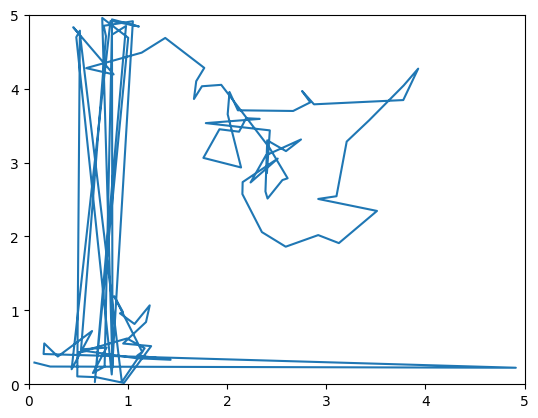

In [7]:
plt.plot(pos[0], pos[1])
plt.xlim(0,env.L); plt.ylim(0,env.L)

## Agent 

In [8]:
from rl_opts.numba.rl_framework import Forager

In [ ]:
agent = Forager(

## Wrapper

In [22]:
#@jitclass
class virtual_wrapper:


    def __init__(self, 
                 # Environment arguments
                 Nt = 1, 
                 L = 5,
                 r = 1,
                 destructive = True,                 
                 lc = np.array([[1.0],[1]]), # Won't enter into effect if destructive = True
                 lc_distribution = 'constant', # Won't enter into effect if destructive = True
                 agent_step = 1, # Won't enter into effect if position is updated with displacements
                 # Agent arguments
                 num_actions = 2, # Number of actions
                 size_state_space = np.array([100]), 
                 # List where each entry is the state space of each perceptual feature. 
                 # In general we only consider one perceptual feature (counter)
                 gamma_damping=0.0, # Gamma of PS
                 eta_glow_damping=0.0, # Glow of PS
                 policy_type='standard', # Sampling of policy
                 beta_softmax=3, # Parameters if policy is softmax
                 initial_prob_distr = np.array([[],[]]), # Initial h-matrix
                 fixed_policy=np.array([[],[]]), # If considering a fixed policy
                 max_no_H_update = int(1e4) # maximum number of steps before an update of H and G matrices.
                 ):
        
        self.env = TargetEnv(Nt,L,r,lc,agent_step,1,destructive,lc_distribution)

        self.agent = Forager(num_actions,size_state_space,gamma_damping,
                             eta_glow_damping,policy_type,beta_softmax,
                             initial_prob_distr,fixed_policy,max_no_H_update)
                 

In [26]:
VW = virtual_wrapper()

In [24]:
VW.env.init_env()

In [28]:
T = int(1e2)
pos = np.zeros((2, T))

VW.env.init_env()
VW.env.positions[0] = np.array([env.L/2, env.L/2])
for t in range(T):
    VW.env.update_pos_disp(np.random.randn(2)*0.3)
    VW.env.check_encounter()
    #check boundary conditions
    VW.env.check_bc()

    
    
    pos[:, t] = VW.env.positions[0]

(0.0, 5.0)

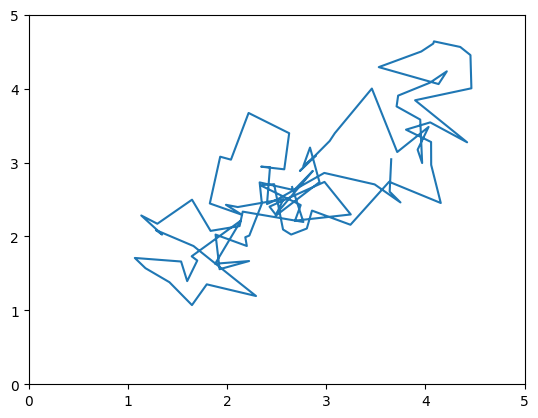

In [29]:
plt.plot(pos[0], pos[1])
plt.xlim(0,env.L); plt.ylim(0,env.L)

#| hide
# nbdev

In [80]:
#| hide
from nbdev import nbdev_export ; nbdev_export()